<a href="https://colab.research.google.com/github/amilyk/Agentic-ai-notes/blob/main/Tool.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import json
import display_functions

In [10]:
# !pip uninstall "docstring-parser==0.14.1"
# !pip uninstall "httpx[http2]==0.27.2"
# !pip uninstall aisuite

# !pip install "docstring-parser>=0.15,<1.0"
# !pip install "httpx[http2]==0.28.1"
# !pip install aisuite --no-deps

# 工具定义

In [4]:
from datetime import datetime
def get_current_time():
    """Returns the current time as a string"""
    return datetime.now().strftime("%H:%M:%S")

In [5]:
get_current_time()

'07:44:45'

In [5]:
# # from datetime import datetime
# from zoneinfo import ZoneInfo

# def get_current_time(timezone):
#     """Returns current time for the given time zone"""
#     timezone = ZoneInfo(timezone)
#     return datetime.now(timezone).strftime("%H:%M:%S")

# 通用智能体客户端

In [7]:
!touch .env
!echo "DEEPSEEK_API_KEY=my-deepseek-api-key" >> .env
!echo "HF_TOKEN=my-hf-api-key" >> .env

In [7]:
import os
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv())

In [8]:
import aisuite as ai

# Create an instance of the AISuite client
client = ai.Client()

In [11]:
# Message structure
prompt = "What time is it?"
messages = [
    {
        "role": "user",
        "content": prompt,
    }
]

response = client.chat.completions.create(
    model="deepseek:deepseek-chat",     # 指定使用的模型
    messages=messages,          # 传递给 LLM 的消息数组
    tools=[get_current_time],   # 定义 LLM 可以访问的工具列表
    max_turns=5                 # 设置工具调用的最大轮次，防止无限循环
)

In [12]:
# See the LLM response
print(response.choices[0].message.content)

The current time is 07:46:19.


# 工具内部

In [13]:
display_functions.pretty_print_chat_completion(response)

# 定义工具并传递给LLM的格式

In [15]:
# tools = [{"type":"function",
#           "function":{
#               "name":"get_current_time",
#               "description":"Return the current time as a string",
#               "parameters":{}
#           }
#         }]
tools = [{
    "type": "function",
    "function": {
        "name": "get_current_time", # <--- Your functions name
        "description": "Returns the current time as a string.", # <--- a description for the LLM
        "parameters": {}
    }
}]

In [16]:
response = client.chat.completions.create(
    model="huggingface:Qwen/Qwen3-VL-235B-A22B-Instruct",
    messages=messages,
    tools=tools,
    # max_turns=5
)
# print(response.choices[0].message.content)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
# aisuite版本

In [14]:
# print(json.dumps(response.model_dump(), indent=2, default=str))

In [17]:
#将tool_call的调用结果返回给LLM，并给出最终结果

response2 = None

# Create a condition in case tool_calls is in response object
if response.choices[0].message.tool_calls:
    # Pull out the specific tool metadata from the response
    tool_call = response.choices[0].message.tool_calls[0]
    args = json.loads(tool_call.function.arguments)

    # Run the tool locally
    tool_result = get_current_time()
    print(tool_result)

    # Append the result to the messages list
    messages.append(response.choices[0].message)
    messages.append({
        "role": "tool", "tool_call_id": tool_call.id, "content": str(tool_result)
    })

    # Send the list of messages with the newly appended results back to the LLM
    response2 = client.chat.completions.create(
        model="deepseek:deepseek-chat",
        messages=messages,
        tools=tools,
    )
    print(response2.choices[0].message.content)

# 增加更多工具

In [23]:
# !pip install qrcode

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.0 MB/s eta 0:00:00


In [18]:
import requests
import qrcode
from qrcode.image.styledpil import StyledPilImage


def get_weather_from_ip():
    """
    Gets the current, high, and low temperature in Fahrenheit for the user's
    location and returns it to the user.
    """
    # Get location coordinates from the IP address
    lat, lon = requests.get('https://ipinfo.io/json').json()['loc'].split(',')

    # Set parameters for the weather API call
    params = {
        "latitude": lat,
        "longitude": lon,
        "current": "temperature_2m",
        "daily": "temperature_2m_max,temperature_2m_min",
        "temperature_unit": "fahrenheit",
        "timezone": "auto"
    }

    # Get weather data
    weather_data = requests.get("https://api.open-meteo.com/v1/forecast", params=params).json()

    # Format and return the simplified string
    return (
        f"Current: {weather_data['current']['temperature_2m']}°F, "
        f"High: {weather_data['daily']['temperature_2m_max'][0]}°F, "
        f"Low: {weather_data['daily']['temperature_2m_min'][0]}°F"
    )

# Write a text file
def write_txt_file(file_path: str, content: str):
    """
    Write a string into a .txt file (overwrites if exists).
    Args:
        file_path (str): Destination path.
        content (str): Text to write.
    Returns:
        str: Path to the written file.
    """
    with open(file_path, "w", encoding="utf-8") as f:
        f.write(content)
    return file_path


# Create a QR code
def generate_qr_code(data: str, filename: str, image_path: str):
    """Generate a QR code image given data and an image path.

    Args:
        data: Text or URL to encode
        filename: Name for the output PNG file (without extension)
        image_path: Path to the image to be used in the QR code
    """
    qr = qrcode.QRCode(error_correction=qrcode.constants.ERROR_CORRECT_H)
    qr.add_data(data)

    img = qr.make_image(image_factory=StyledPilImage, embedded_image_path=image_path)
    output_file = f"{filename}.png"
    img.save(output_file)

    return f"QR code saved as {output_file} containing: {data[:50]}..."

In [19]:
prompt = "Can you get the weather for my location?"

response = client.chat.completions.create(
    model="huggingface:Qwen/Qwen3-4B-Instruct-2507",
    messages=[{"role": "user", "content": (
        prompt
    )}],
    tools=[
        get_current_time,
        get_weather_from_ip,
        write_txt_file,
        generate_qr_code
    ],
    max_turns=5
)

In [20]:
display_functions.pretty_print_chat_completion(response)

In [21]:
prompt = "Can you make a txt note for me called reminders.txt that reminds me to call Daniel tomorrow at 7PM?"

response = client.chat.completions.create(
    model="huggingface:Qwen/Qwen3-4B-Instruct-2507",
    messages=[{"role": "user", "content": (
        prompt
    )}],
    tools=[
        get_current_time,
        get_weather_from_ip,
        write_txt_file,
        generate_qr_code
    ],
    max_turns=5
)

display_functions.pretty_print_chat_completion(response)

In [22]:
with open('reminders.txt', 'r') as file:
    contents = file.read()
    print(contents)

Remember to call Daniel tomorrow at 7 PM.


In [23]:
prompt = "Can you make a QR code for me using my company's logo that goes to www.deeplearning.ai? The logo is located at `dl_logo.jpg`. You can call it dl_qr_code."

response = client.chat.completions.create(
    model="huggingface:Qwen/Qwen3-VL-8B-Instruct",
    messages=[{"role": "user", "content": (
        prompt
    )}],
    tools=[
        get_current_time,
        get_weather_from_ip,
        write_txt_file,
        generate_qr_code
    ],
    max_turns=5
)

display_functions.pretty_print_chat_completion(response)

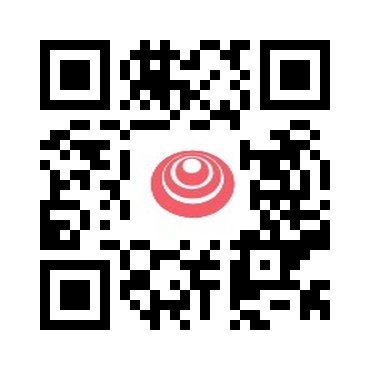

In [24]:
from IPython.display import Image, display

# Display image directly
Image('dl_qr_code.png')

# 一次使用多个工具

In [25]:
prompt = "Can you help me create a qr code that goes to www.deeplearning.com from the image dl_logo.jpg? Also write me a txt note with the current weather please."

response = client.chat.completions.create(
    model="huggingface:Qwen/Qwen3-VL-8B-Instruct",
    messages=[{"role": "user", "content": (
        prompt
    )}],
    tools=[
        get_weather_from_ip,
        get_current_time,
        write_txt_file,
        generate_qr_code
    ],
    max_turns=10
)

display_functions.pretty_print_chat_completion(response)

In [ ]:
#调用多个工具，LLM会影响结果
#gpt
#Qwen哪个chat支持多模态比较好